In [67]:
import numpy as np
import stat as st
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import scipy.stats as scs
import matplotlib.pyplot as plt
import math
from pandas.tools.plotting import autocorrelation_plot
from pandas import read_csv, DataFrame
from sklearn.metrics import r2_score
import datetime
import copy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Функции

In [68]:
df = pd.read_csv('month_dasha.csv', sep=';', keep_default_na=False)
data = df.cost

In [69]:
def stat(x):
    _x = x  # Для возможности предобработки данных (например, исключения нечисловых значений) 
    print('счет', len(x))
    print('среднее', (np.mean(_x)))
    print('минимальное', np.min(_x), 'и максимальное', np.max(_x))
    print('стандартное отклонение', pd.core.groupby.GroupBy.std(_x))
    print('дисперсия', np.var(_x))
    print('коэффициент вариации', (np.std(_x)) / (np.mean(_x)))
    print('коэффициент асимметрии', scs.skew(_x))  # асимметрия 
    print('эксцесс', scs.kurtosis(_x)) # эксцесс


def student(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    t_statistic, p_value = scs.ttest_ind(group1, group2)
    print("two-sample t-test:")
    print('p_value =', p_value)
    print('t_statistic =', t_statistic)


def student2(data):
    r = 0
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) != np.var(group2):
        t = (abs(np.mean(group1) - np.mean(group2))) / math.sqrt(
            (np.var(group1) / len(group1) + np.var(group2) / len(group2)))
        print('дисперсии не равны')
        print('критерий Стьюдента =', t)
    else:
        t = ((abs(np.mean(group1) - np.mean(group2))) / np.var(group2)) * (math.sqrt(
            (len(group1) * len(group2)) / (len(group1) + len(group2))))
        print('дисперсии равны')
        print('критерий Стьюдента =', t)


def mann2(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    # Если данные не распределены нормально, применяем критерий Манна-Уитни, также известный как 
    # Критерий Уилкоксона для двух выборок
    u, p_value = scs.mannwhitneyu(group1, group2, alternative='two-sided')
    g1 = len(group1)
    g2 = len(group2)
    print('two-sample wilcoxon-test(mann-whitneyu), p_value =', p_value)
    print('U =', u)
    print('M(U) =', g1 * g2 / 2)
    print('D(U) =', g1 * g2 * (g1 + g2 + 1) / 12)
    if (u - (g1 * g2 / 2)) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12) > 0:
        z = (u - (g1 * g2 / 2) - 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    else:
        z = (u - (g1 * g2 / 2) + 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    print('Z =', z)


def fisher(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) >= np.var(group2):
        f = np.var(group1) / np.var(group2)
    else:
        f = np.var(group2) / np.var(group1)
    print('критерий Фишера =', f)


def acf_and_pacf(data, lags=None):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()


def mann(x):
    x = list(x)
    s = [0] * len(x)
    for i in range(len(x)):
        s[i] = i + 1
    k = 1
    t1 = int(len(x) / 2)
    t2 = len(x) - t1
    print('Группа 1 и 2:', t1, 'и', t2)
    for i in range(len(x)):
        if k <= t1:
            x[i] = [x[i], 1]
        else:
            x[i] = [x[i], 2]
        k += 1
    x.sort()
    r1 = 0
    r2 = 0
    for i in range(len(x)):
        if x[i][1] == 1:
            r1 += s[i]
        else:
            r2 += s[i]
    print('сумма рангов r1 =', r1)
    print('сумма рангов r2 =', r2)
    u1 = r1 - (t1 * (t1 + 1)) / 2
    u2 = t1 * t2 - (t2 * ( t2 + 1)) / 2 - r2
    mu = (t1 * t2) / 2
    du = (t1 * t2 * (t1 + t2 + 1)) / 12
    z = (u1 - (t1 * t2) / 2) / (sqrt(du))
    if z > 0:
        z = (u1 - (t1 * t2) / 2 - 1 / 2) / (sqrt(du))
    else:
        z = (u1 - (t1 * t2) / 2 + 1 / 2) / (sqrt(du))
    print('U =', u1)
    print('M(U) =', mu)
    print('D(U) =', du)
    print('Z =', z)
    if -1.96 <= z <= 1.96:
        print('гипотеза о постоянстве постоянстве мат. ожидания принимается')
    else:
        print('гипотеза о постоянстве постоянстве мат. ожидания не принимается')


def sijel(x):
    x = list(x)
    sr = np.mean(x)
    s = [0] * len(x)
    for i in range(int(len(x) / 2)):
        s[i] = 2 * i + 1
        s[-i - 1] = 2 * i + 2
    if s[int(len(x) / 2)] == 0:
        s[int(len(x) / 2)] = 2 * (int(len(x) / 2) + 1)
    k = 1
    t1 = int(len(x) / 2)
    t2 = len(x) - t1
    print('Группа 1 и 2:', t1, 'и', t2)
    for i in range(len(x)):
        x[i] = x[i] - sr
    for i in range(len(x)):
        if k <= t1:
            x[i] = [x[i], 1]
        else:
            x[i] = [x[i], 2]
        k += 1
    x.sort()
    r1 = 0
    r2 = 0
    for i in range(len(x)):
        if x[i][1] == 1:
            r1 += s[i]
        else:
            r2 += s[i]
    print('сумма рангов r1 =', r1)
    print('сумма рангов r2 =', r2)
    mw = r1 - t1* (t1 + t2 + 1) / 2
    dw = (t1 * t2 * (t1 + t2 + 1)) / 12
    z = (r1 - (t1 * ( t1 + t2 + 1)) / 2) / (sqrt(dw))
    if z > 0:
        z = (r1 - (t1 * ( t1 + t2 + 1)) / 2 - 1 / 2) / (sqrt(dw))
    else:
        z = (r1 - (t1 * ( t1 + t2 + 1)) / 2 + 1 / 2) / (sqrt(dw))
    print('M(U) =', mw)
    print('D(U) =', dw)
    print('Z =', z)
    if -1.96 <= z <= 1.96:
        print('гипотеза о постоянстве постоянстве дисперсии принимается')
    else:
        print('гипотеза о постоянстве постоянстве дисперсии не принимается')



# Решение

In [70]:
stat(data)

счет 61
среднее 1.19810229508
минимальное 1.05241 и максимальное 1.3865
стандартное отклонение 0.110149355413
дисперсия 0.0119339808177
коэффициент вариации 0.0911798277893
коэффициент асимметрии 0.40170570070884787
эксцесс -1.3463083174371846


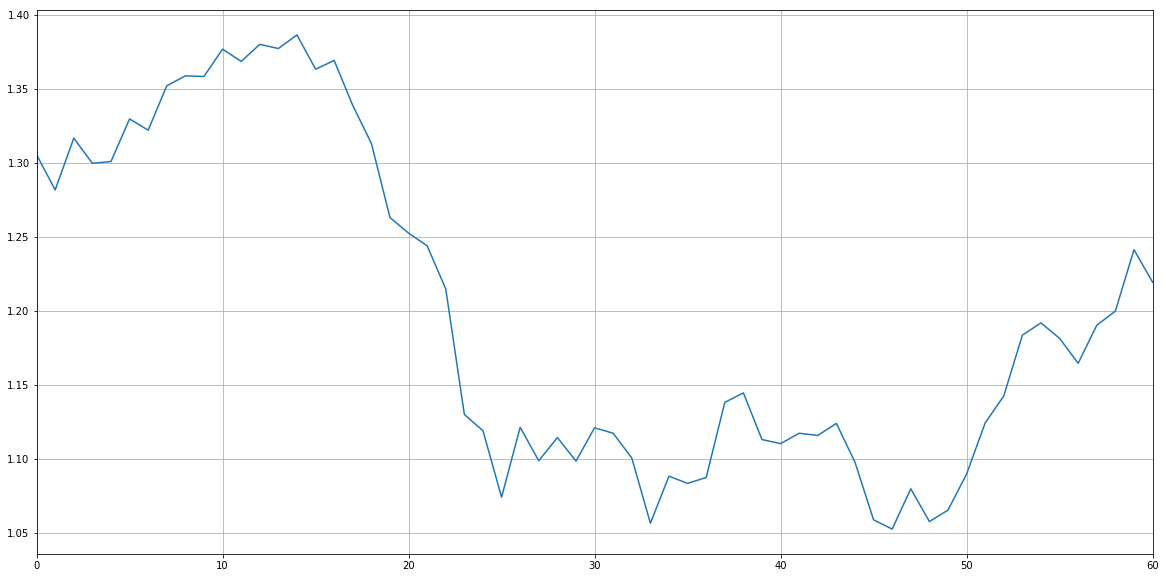

In [71]:
data.plot(figsize=(20, 10), grid=True)
plt.show()

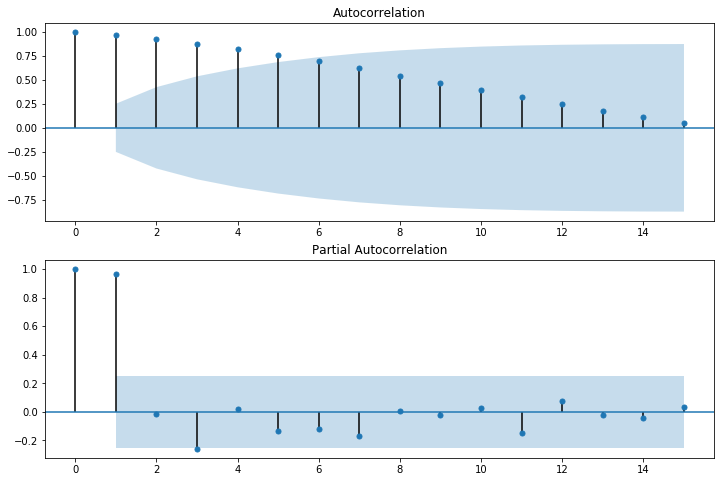

In [72]:
acf_and_pacf(data, lags=(len(data) / 4))

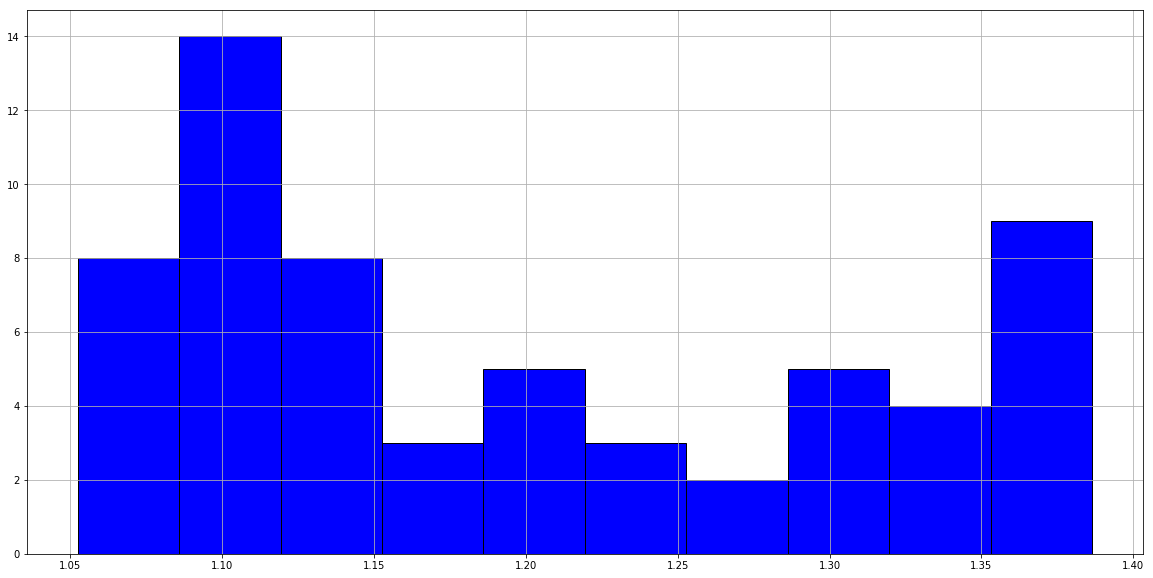

In [73]:
data.hist(figsize=(20, 10), bins=10, color="blue", edgecolor='black')
plt.show()

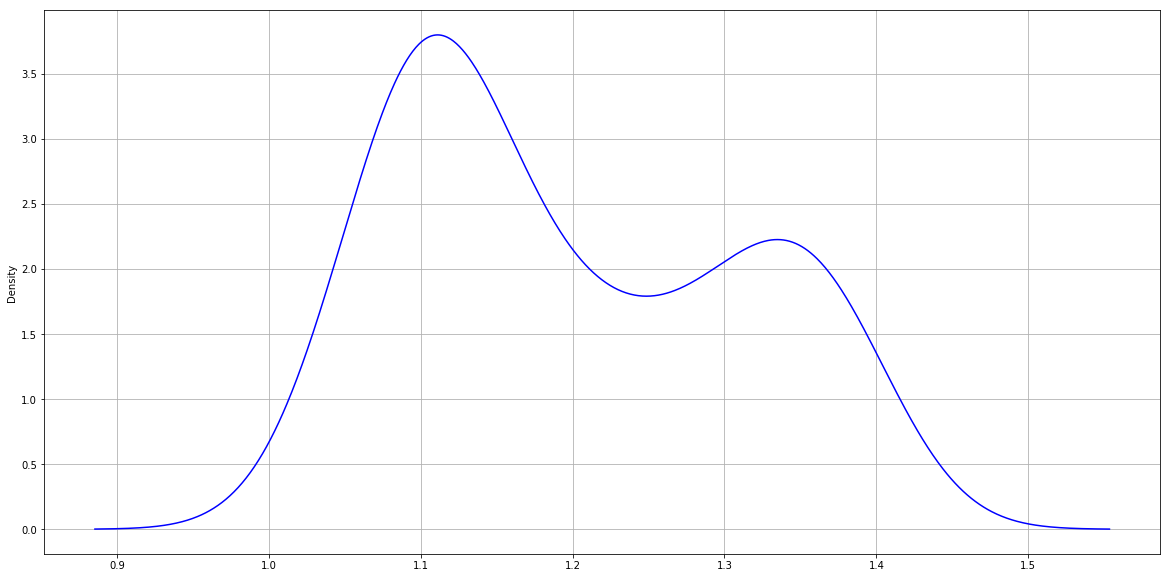

In [74]:
data.plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

In [75]:
model = data
model = 0.043341972 + 0.962603931 * model.shift(1)
ost = data - model

In [76]:
stat(ost[1:])

счет 60
среднее 1.24655820145e-05
минимальное -0.0827169669857 и максимальное 0.0480880259023
стандартное отклонение 0.0260618281652
дисперсия 0.000667898572526
коэффициент вариации 2073.20714658
коэффициент асимметрии -0.4273605704732174
эксцесс 0.40309120511815033


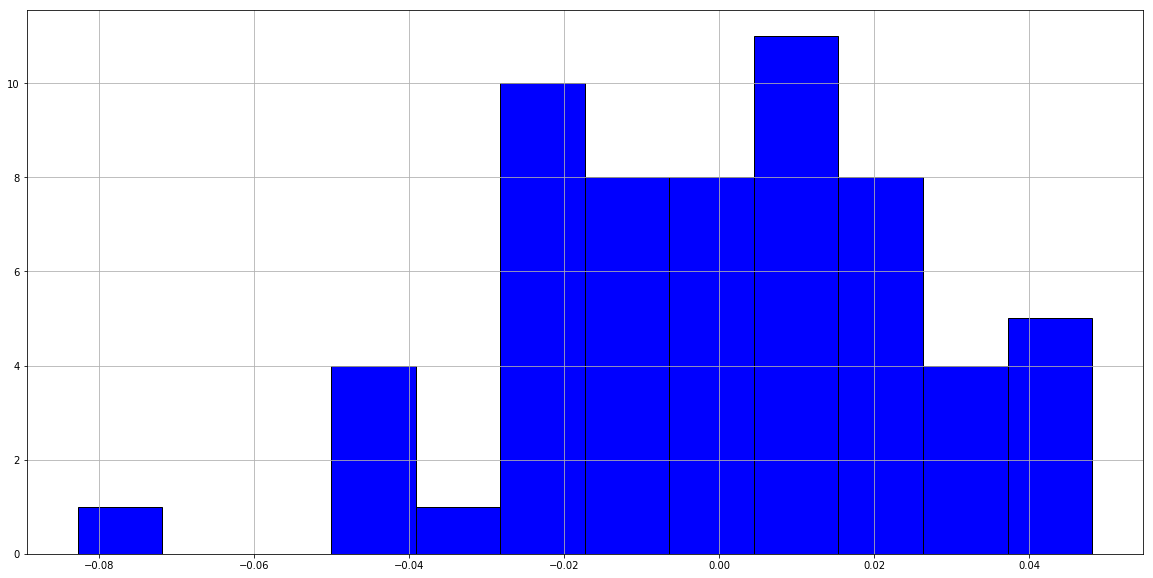

In [77]:
ost[1:].hist(figsize=(20, 10), bins=12, color="blue", edgecolor='black')
plt.show()

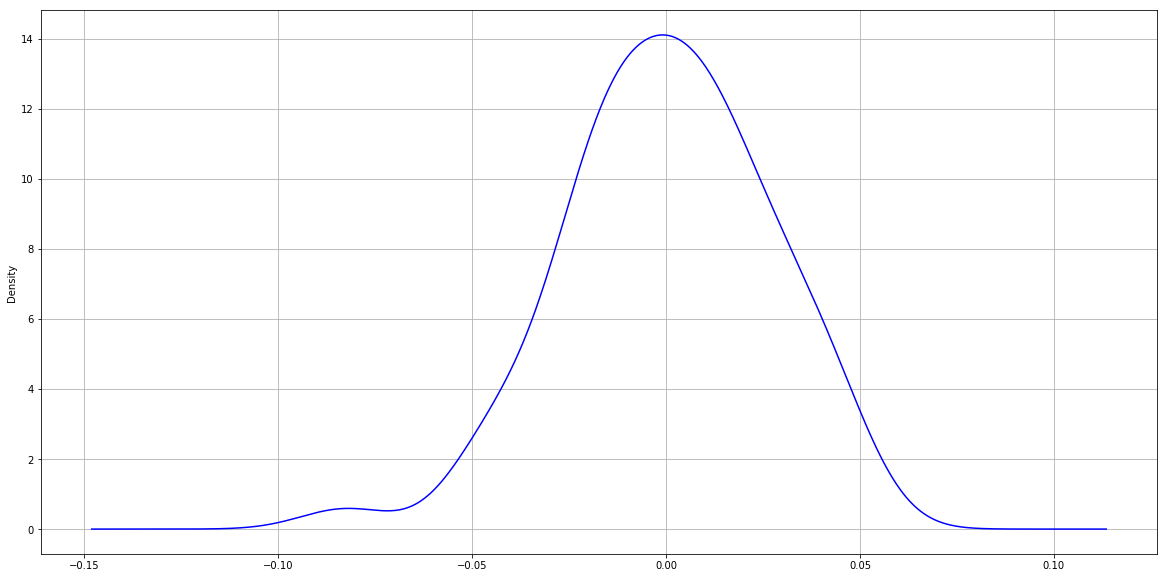

In [78]:
ost[1:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

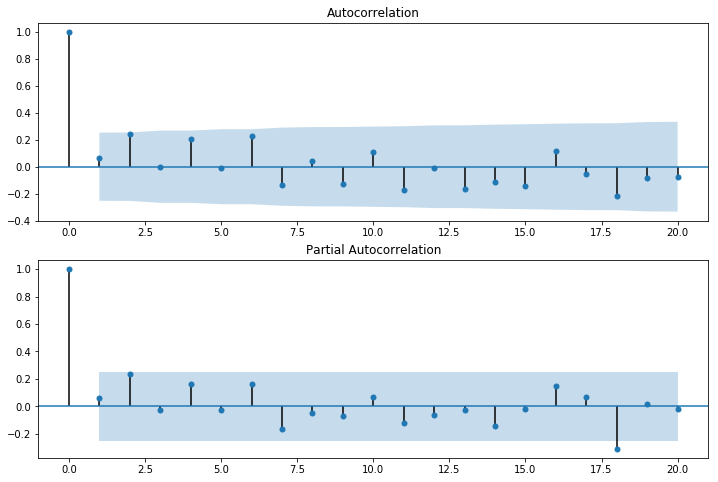

In [79]:
acf_and_pacf(ost[1:], lags=(20))

In [81]:
sijel(ost[1:])

Группа 1 и 2: 30 и 30
сумма рангов r1 = 888
сумма рангов r2 = 942
M(U) = -27.0
D(U) = 4575.0
Z = -0.391787273606
гипотеза о постоянстве постоянстве дисперсии принимается
